In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import tensorflow


from sklearn.preprocessing import MinMaxScaler
  
import joblib
 


In [11]:
from tensorflow import keras

In [1]:
from keras.models import Sequential

In [19]:
from keras.layers import Conv1D, LSTM, Dense, Dropout

In [2]:
df = pd.read_csv('../data/station_hourly_data.csv', parse_dates=['Datetime'], low_memory=False)


Load and Preprocess Data

In [3]:
df = pd.read_csv('../data/station_hourly_data.csv', parse_dates=['Datetime'])
df = df[df['StationId'] == 'DL001']  # Focus on one station (Delhi)
df = df[['Datetime', 'PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3']]  # Use relevant columns

# Time features
df['hour'] = df['Datetime'].dt.hour
df['day'] = df['Datetime'].dt.day
df['month'] = df['Datetime'].dt.month
df['weekday'] = df['Datetime'].dt.weekday
df.set_index('Datetime', inplace=True)

# Handle missing values
df = df.fillna(method='ffill')


C:\Users\LOQ\AppData\Local\Temp\ipykernel_27384\3655666891.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/station_hourly_data.csv', parse_dates=['Datetime'])
C:\Users\LOQ\AppData\Local\Temp\ipykernel_27384\3655666891.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


Normalize Features

In [4]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)
df_scaled = pd.DataFrame(scaled_data, columns=df.columns, index=df.index)

# Save scaler for inverse prediction later
joblib.dump(scaler, '../models/scaler.pkl')


['../models/scaler.pkl']

Create Sequences for LSTM + CNN

In [5]:
def create_sequences(data, target_col='PM2.5', window=24):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data.iloc[i:i+window].values)
        y.append(data.iloc[i+window][target_col])
    return np.array(X), np.array(y)

X, y = create_sequences(df_scaled, target_col='PM2.5', window=24)

# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (11451, 24, 10)
y_train shape: (11451,)


In [24]:
 model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64),
    Dropout(0.3),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 22, 64)              │           1,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,073 (137.00 KB)

 Trainable params: 35,073 (137.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: nan - val_loss: nan
Epoch 2/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: nan - val_loss: nan
Epoch 3/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: nan - val_loss: nan
Epoch 4/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: nan - val_loss: nan
Epoch 5/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: nan - val_loss: nan
Epoch 6/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: nan - val_loss: nan
Epoch 7/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: nan - val_loss: nan
Epoch 8/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: nan - val_loss: nan
Epoch 9/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: nan - val_loss: nan
Epoch 10/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: nan - val_loss: nan
Epoch 11/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: nan - val_loss: nan
Epoch 12/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: nan - val_loss: nan
Epoch 13/20
287/287 ━━━

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


C:\Users\LOQ\AppData\Local\Temp\ipykernel_27384\3599719225.py:5: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  dummy_df = pd.read_csv('../data/station_hourly_data.csv')  # For shape reference


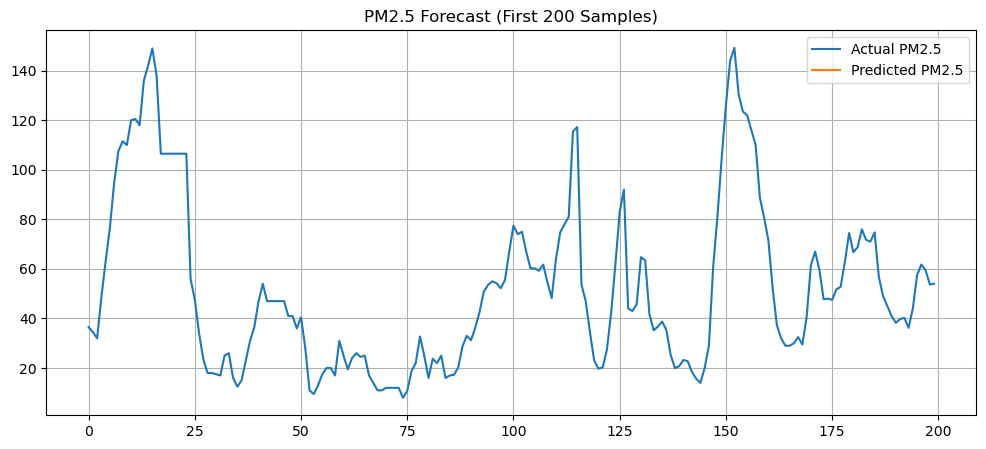

In [26]:
y_pred = model.predict(X_test)

# Inverse transform predictions
scaler = joblib.load('../models/scaler.pkl')
dummy_df = pd.read_csv('../data/station_hourly_data.csv')  # For shape reference
n_features = df.shape[1]

# Pad with zeros to reverse scaling
pad_pred = np.zeros((len(y_pred), n_features))
pad_pred[:, 0] = y_pred.flatten()
inv_pred = scaler.inverse_transform(pad_pred)[:, 0]

pad_true = np.zeros((len(y_test), n_features))
pad_true[:, 0] = y_test.flatten()
inv_true = scaler.inverse_transform(pad_true)[:, 0]

# Plot results
plt.figure(figsize=(12,5))
plt.plot(inv_true[:200], label='Actual PM2.5')
plt.plot(inv_pred[:200], label='Predicted PM2.5')
plt.title("PM2.5 Forecast (First 200 Samples)")
plt.legend()
plt.grid(True)
plt.show()


In [28]:
 model.save('../models/lstm_cnn_model.keras')
print("✅ Model saved!")


✅ Model saved!
